# BERT FOR RELATION EXTRACTION
The following script, represents the practical deliverable of the 3rd Bachelor Semester Project (BSP S3) of Tarik Tornes, under the supervision of Prof. Martin Theobald.
The script treats all the steps of analyzing and preprocessing necessary data, creating, training and evaluating an finetuned transformer based model (i.e. BERT).


### Structure
1. Import necessary modules/libraries
2. Checking Setup (MPS)
3. Loading and preprocessing dataset
    1. Methods for data processing
    2. Original KnowledgeNet Dataset (Processing and Saving)
    3. Loading MODIFIED KnowledgeNet DataFrame
    4. Additional Realtions (PLACE_OF_DEATH  &. AUTHOR)
    5. Grouping and finalization of Preprocessing
4. Relation Extraction Model
    1. Loading and initializing the RE model
    2. Training BERT-Model
    3. Saving the trained model
    4. Loading a saved model
5. Model Evaluation
    1. Methods for the Model Evaluation
    2. Prediction on Testing Set
    3. Evaluating the Model
6. FewShot-Learning Experiment
    1. Necessary Methods and Variables
    2. DataSet Subdivision
    3. Running the FewShot-Learning Experiment (Re-Training)
    4. Running the FewShot-Learning Experiment (Already trained)
    5. Ploting the results of the Experiment
7. Extra: Threshold testing
    

## 1. Import modules/libraries

In [1]:
# Modules specially for machine learning
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Modules for data science in general
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# basic python modules
import os
import json
import random
from tqdm import tqdm

## 2. Checking Setup (MPS)
Since this project was created on an Apple MacBook Pro with an M1 Silicon Chip, it is necessary to setup the mps api, such that we can train the model efficiently on the neural engine of the M1 Chip. Training the same without MPS, on Google Colab for example takes 10-11x more time.
(GitHub: https://github.com/mrdbourke/pytorch-apple-silicon)

In [2]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")
# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Create data and send it to the device
x = torch.rand(size=(3, 4)).to(device)
x

PyTorch version: 2.1.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


tensor([[0.4154, 0.9801, 0.6582, 0.6502],
        [0.4823, 0.0475, 0.2431, 0.3311],
        [0.8869, 0.1791, 0.0892, 0.8741]], device='mps:0')

## 3. Loading and preprocessing dataset
To fine-tune/train the BERT model for Relation Extraction, the initial step involves loading and preprocessing a well-suited dataset with accurate labeling. For this purpose, we'll leverage the KnowledgeNet Dataset, meticulously labeled for 15 distinct relations across 4 folds. The task entails conducting Relation Extraction on individual passages or sentences, training the model for both multilabeling and multiclassification.

(*KnowledgeNet Dataset: https://github.com/diffbot/knowledge-net/blob/master/dataset/train.json*)

**Relations:**
1. SUBSIDIARY_OF
2. FOUNDED_BY
3. EMPLOYEE_OR_MEMBER_OF
4. CEO
5. DATE_FOUNDED
6. HEADQUARTERS
7. EDUCATED_AT
8. NATIONALITY
9. PLACE_OF_RESIDENCE
10. PLACE_OF_BIRTH
11. DATE_OF_DEATH
12. DATE_OF_BIRTH
13. SPOUSE
14. CHILD_OF
15. POLITICAL_AFFILIATION
16. PLACE_OF_DEATH (new relations)
17. AUTHOR         (new relations)


### 3.A. Methods for data porcessing
We are defining some methods for the processing of the data.

In [3]:
# dictionary which matches the propertyID to the correct "human readable" relation
rel_dict = {
    "1": "SUBSIDIARY_OF",
    "2": "FOUNDED_BY",
    "3": "EMPLOYEE_OR_MEMBER_OF",
    "4": "CEO",
    "5": "DATE_FOUNDED",
    "6": "HEADQUARTERS",
    "9": "EDUCATED_AT",
    "10": "NATIONALITY",
    "11": "PLACE_OF_RESIDENCE",
    "12": "PLACE_OF_BIRTH",
    "14": "DATE_OF_DEATH",
    "15": "DATE_OF_BIRTH",
    "20": "PLACE_OF_DEATH",
    "25": "SPOUSE",
    "34": "CHILD_OF",
    "45": "POLITICAL_AFFILIATION",
    "50": "AUTHOR",
}

rel_idx = {
    "SUBSIDIARY_OF": "0",
    "FOUNDED_BY": "1",
    "EMPLOYEE_OR_MEMBER_OF": "2",
    "CEO": "3",
    "DATE_FOUNDED": "4",
    "HEADQUARTERS": "5",
    "EDUCATED_AT": "6",
    "NATIONALITY": "7",
    "PLACE_OF_RESIDENCE": "8",
    "PLACE_OF_BIRTH": "9",
    "DATE_OF_DEATH": "10",
    "DATE_OF_BIRTH": "11",
    "SPOUSE": "12",
    "CHILD_OF": "13",
    "POLITICAL_AFFILIATION": "14",
    "PLACE_OF_DEATH": "15",
    "AUTHOR": "16"
    }

def label_to_multilabelVec(ls):
    ''' 
    Transforms a human readable label (resp. relations) into a vector which can store multiple labels in one vector
    for multi-label classification
    @param ls:    is a list containing all the relations which correspond to one passage example
    @return res:  list/vector representing the multi label
    '''
    # ls ... [SUBSIDIARY_OF, FOUNDED_BY, EMPLOYEE_OR_MEMBER_OF, CEO, DATE_FOUNDED, HEADQUARTERS, EDUCATED_AT, NATIONALITY, PLACE_OF_RESIDENCE, PLACE_OF_BIRTH, DATE_OF_DEATH, DATE_OF_BIRTH, SPOUSE, CHILD_OF, POLITICAL_AFFILIATION, PLACE_OF_DEATH, AUTHOR] 
    rel_idx = {
    "SUBSIDIARY_OF": "0",
    "FOUNDED_BY": "1",
    "EMPLOYEE_OR_MEMBER_OF": "2",
    "CEO": "3",
    "DATE_FOUNDED": "4",
    "HEADQUARTERS": "5",
    "EDUCATED_AT": "6",
    "NATIONALITY": "7",
    "PLACE_OF_RESIDENCE": "8",
    "PLACE_OF_BIRTH": "9",
    "DATE_OF_DEATH": "10",
    "DATE_OF_BIRTH": "11",
    "SPOUSE": "12",
    "CHILD_OF": "13",
    "POLITICAL_AFFILIATION": "14",
    "PLACE_OF_DEATH": "15",
    "AUTHOR": "16"
    }
    
    res = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    for i in ls:
        rl = i.strip(" ")
        res[int(rel_idx[rl])] = 1

    return res

## !! DO NOT EXECUTE A CELL OF THIS SECTION !!
### 3.B. Original KnowledgeNet Dataset (Processing and Saving)  

In this section the original KnowledgeNet (KN) dataset will be loaded and preprocessed and loaded into a dataframe.
Since we are interested in the dataset with the 2 new relations PLACE_OF_DEATH and AUTHOR, we need to load instead a manually modified version of the KN Dataset (cf. 3.C) since, some training examples had to be deleted which would lead to a contradiction when adding the new labels, in order to obtain the best performance.

In [ ]:
# file path to the original KN dataset
train_filepath = '../../Dataset/KN_data.json'


# Initialize an empty list to store the JSON objects
data = []

# Open and read the JSON file line by line
with open(train_filepath, 'r') as file:
    for line in file:
        try:
            # Parse each line as a JSON object and append it to the data list
            json_obj = json.loads(line)
            data.append(json_obj)
        except json.JSONDecodeError as e:
            print(f"Skipping invalid JSON: {e}")
            
            

# Create an empty DataFrame with columns
columns = ['fold', 'documentID', 'passageID', 'factID', 'relation', 'propertyID', 'subject', 'object', 'annotatedPassage', 'passageText', 'documentText']
df = pd.DataFrame(columns=columns)

# Display the empty DataFrame
print(df)

for document in data:
    #print(document)
    fold = document['fold']
    docText = document['documentText']
    docID = document['documentId']
    
    for passage in document['passages']:
        passageID = passage['passageId']
        passageText = passage['passageText']
        if passage['facts'] == []:
            continue
        else:
            for fact in passage['facts']:
                factID = fact['factId']
                factText = fact['annotatedPassage']
                propID = fact['propertyId']
                relation = rel_dict[str(propID)]
                subj = fact['subjectText']
                obj = fact['objectText']
                
                new_row = {
                    'fold' : fold,
                    'documentID' : docID,
                    'passageID' : passageID,
                    'factID' : factID,
                    'relation' : relation,
                    'propertyID' : propID,
                    'subject' : subj,
                    'object' : obj,
                    'annotatedPassage' : factText,
                    'passageText' : passageText,
                    'documentText' : docText
                }
                
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
col = ['fold', 'passageText', 'label']
df_kn = pd.DataFrame(columns=col)

# Copy one column as it is to the new dataframe
df_kn['fold'] = df['fold']
df_kn['passageText'] = df['passageText']

#df_kn['documentID'] = df['documentID']
df_kn['label'] = df['relation']

# grouping dataset by the same sentences and gathering the distinct "single" labels into a multilabel list
df_kn = df_kn.groupby(['passageText', 'fold'])['label'].apply(list).reset_index()
df_kn['label'] = df_kn['label'].apply(lambda x: list(set(x)))
df_kn

**Saving the processed dataframe of the original dataset**

In [ ]:
csv_file_path = 'df_kn.csv'  # File path to save the Excel file
df_kn.to_csv(csv_file_path, index=False)

# Provide a link to download the file
from IPython.display import File311Link
display(FileLink(csv_file_path))

### 3.C. Loading MODIFIED KnowledgeNet DataFrame
The following section loads the preprocessed KN data from a csv file (see sec. 3.B.) into a pandas DataFrame.
The file df2_kn.csv, represents the original dataset, modified to the extent such that all sentences containg predicates related to "PLACE_OF_DEATH" and "AUTHOR" are removed, to avoid contradictive training data when labeling sentences for those new relations.

In [4]:
fileDf = '../../Dataset/df2_kn.csv'
df_kn = pd.read_csv(fileDf, delimiter='\t', names=["passageText", "fold", "label"])
df_kn['label'] = df_kn['label'].apply(lambda x: x.strip("["))
df_kn['label'] = df_kn['label'].apply(lambda x: x.strip("]"))
df_kn['label'] = df_kn['label'].apply(lambda x: x.strip(" "))
df_kn['label'] = df_kn['label'].apply(lambda x: x.split(","))
df_kn

,passageText,fold,label
0,"""Chapman Kelly is a major force in the depende...",4,[CEO]
1,"""In 1937 Beveridge was awarded a Commonwealth ...",4,[CHILD_OF]
2,"""Marianne Charlotte, eldest daughter of George...",4,[DATE_OF_DEATH]
3,"""Reactivity Mafia"" also produced other notable...",3,[FOUNDED_BY]
4,"""Take Me Home, Country Roads"" may be the (unof...",2,[SUBSIDIARY_OF]
...,...,...,...
3282,"premises in heart of Pune city, which has a ca...",1,[SUBSIDIARY_OF]
3283,{{Infobox connector...}} Athina Krikeli (Greek...,2,[PLACE_OF_BIRTH]
3284,"~Frederick Douglass Born 1966, lived in Marion...",2,[CHILD_OF]
3285,Žarko Petan was one of the founding members of...,3,"[FOUNDED_BY, EMPLOYEE_OR_MEMBER_OF]"


### 3.D. Additional Realtions (PLACE_OF_DEATH  &. AUTHOR)
The following section is responsible for loading and preprocessing the dataset for the PLACE_OF_DEATH (POD) and AUTHOR relations. The training sentences were picked from the KN dataset and manually labelled.

**PLACE_OF_DEATH**

In [5]:
# Filepath to POD dataset
file = '../../Dataset/KNPOD.tsv'

df_POD = pd.read_csv(file, delimiter='\t', names=["passageText", "label"])
df_POD["label"] = df_POD["label"].apply(lambda s: s.split(","))

df_POD = df_POD.assign(fold=pd.Series())
#df_POD = df_POD.assign(documentID=pd.Series())

# Shuffle the DataFrame
df_POD = df_POD.sample(frac=1, random_state=42).reset_index(drop=True)

# Total number of integers
total_integers = 71

# List of integers to repeat
integers = [1, 2, 3, 4]

# Calculate the number of times each integer should be repeated
repeat_count = total_integers // len(integers)

# Generate the list of integers
result = integers * repeat_count

# Add any remaining integers if needed
remaining = total_integers - len(result)
if remaining > 0:
    result += random.choices(integers, k=remaining)

df_POD['fold'] = result
df_POD

,passageText,label,fold
0,He died in Kyoto in September 2012.,"[PLACE_OF_DEATH, DATE_OF_DEATH]",1
1,Huber never served any prison time and died in...,"[PLACE_OF_DEATH, DATE_OF_DEATH]",2
2,He died in New Castle.,[PLACE_OF_DEATH],3
3,"François-Henri Clicquot, at that time the lead...","[PLACE_OF_DEATH, DATE_OF_DEATH]",4
4,He died in Berlin.,[PLACE_OF_DEATH],1
...,...,...,...
66,He was born in New York City and died in Los A...,"[PLACE_OF_DEATH, PLACE_OF_BIRTH]",3
67,"He died in Cleveland on October 5, 1887, and w...","[PLACE_OF_DEATH, DATE_OF_DEATH]",4
68,He died in Garons.,[PLACE_OF_DEATH],4
69,"James died in 1792 at Niagara District, Upper ...","[PLACE_OF_DEATH, DATE_OF_DEATH]",3


**AUTHOR**

In [6]:
file = '../../Dataset/author.tsv'
df_ATH = pd.read_csv(file, delimiter='\t', names=["passageText", "label"])
df_ATH["label"] = df_ATH["label"].apply(lambda s: s.split(","))

df_ATH = df_ATH.assign(fold=pd.Series())
# df_ATH = df_ATH.assign(documentID=pd.Series())

# Shuffle the DataFrame
df_ATH = df_ATH.sample(frac=1, random_state=42).reset_index(drop=True)

# Total number of integers
total_integers = 114

# List of integers to repeat
integers = [1, 2, 3, 4]

# Calculate the number of times each integer should be repeated
repeat_count = total_integers // len(integers)

# Generate the list of integers
result = integers * repeat_count

# Add any remaining integers if needed
remaining = total_integers - len(result)
if remaining > 0:
    result += random.choices(integers, k=remaining)

    
df_ATH['fold'] = result
df_ATH

,passageText,label,fold
0,He also wrote a column in the Daily Nation eve...,[AUTHOR],1
1,"He is the author of many award winning books, ...","[AUTHOR, CEO]",2
2,"In 1984, he and Schonfeld co-authored a work c...",[AUTHOR],3
3,He is the author of numerous works on educatio...,[AUTHOR],4
4,He was the father of chemist Bernard Vonnegut ...,[AUTHOR],1
...,...,...,...
109,"Robert Bagg (born 1935, New Jersey) is an Amer...","[AUTHOR, PLACE_OF_BIRTH, DATE_OF_BIRTH, NATION...",2
110,He is the former Chief executive officer of HC...,"[AUTHOR, CEO]",3
111,"Howard Storm (born October 26, 1946) is an Ame...","[AUTHOR, DATE_OF_BIRTH, NATIONALITY]",4
112,"Cordwainer Smith (/ˈkɔːrdweɪnər/, KORD-waynər)...","[AUTHOR, NATIONALITY]",2


### 3.E. Grouping and finalization of Preprocessing
The following describes how the large/general dataframe (which contains the 15 original KN relations) is merged with the new ones (i.e. 3.D.).

In [7]:
df_grouped = pd.concat([df_kn, df_POD, df_ATH], ignore_index=True)
df_grouped['label'] = df_grouped['label'].apply(label_to_multilabelVec)
df_final = df_grouped

df_fold1 = df_final[df_final['fold'] == 1]
df_fold2 = df_final[df_final['fold'] == 2]
df_fold3 = df_final[df_final['fold'] == 3]
df_fold4 = df_final[df_final['fold'] == 4]
#df_fold5 = df3[df3['fold'] == 5]

train_df = pd.concat([df_fold1, df_fold2, df_fold3], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = df_fold4.sample(frac=1, random_state=42).reset_index(drop=True)
#train_df

In [8]:
# We can check how often a relation occurs in the training/testing set
# train_df => training set
# val_df   => testing set
Relation = "AUTHOR"
type_of_set = val_df

count = (type_of_set['label'].apply(lambda x: x[int(rel_idx[Relation])] == 1)).sum()
print(count)

28


## 4. Relation Extraction Model

### 4.A. Loading and initializing the RE model
This code section sets up a training pipeline for a BERT text model for multi-label and multiclass text classification. It initializes hyperparameters like batch size, epochs, and learning rate.
It uses a pre-trained BERT tokenizer to preprocess text data, tokenizing, padding, etc..
The code initializes a BERT model for sequence classification, defines the loss function (Binary Cross Entropy), optimizer (AdamW), and scheduler.\
We are using **BERT-Base-uncased** for sequence classification


**Results for different parameters (i.e. #epochs & learning rate) :**


In [ ]:
batch_size = 8
num_epochs = 10
learning_rate = 2e-5
max_sequence_length = 128  # Maximum sequence length for padding

# We use a pretrained BERTTokenizer from huggingface
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert labels(hot encoded vectors) to tensors
labels = torch.tensor(train_df['label'].tolist(), dtype=torch.float32)
print(len(labels[0]))
# Create a list with all the facts as training input
texts = train_df['passageText'].tolist()

# Tokenize, pad, and create input masks
input_ids = []
attention_masks = []

for text in texts:
    # take a fact from list texts and convert it into tokens, which are then directly transformed into tensors
    encoding = tokenizer(text, truncation=True, padding='max_length', max_length=max_sequence_length, return_tensors='pt')
    # Take the inputId of the tensor and put the in separate list
    input_ids.append(encoding['input_ids'])
    # Take the attention_mask of the tensor and put the in separate list
    attention_masks.append(encoding['attention_mask'])

# Convert lists of tensors into a batch
input_ids = torch.cat(input_ids, dim=0)  # Use torch.cat to concatenate tensors
attention_masks = torch.cat(attention_masks, dim=0)

# Create DataLoader for training
# Create the final dataset we will input into the model for training
dataset = TensorDataset(input_ids, attention_masks, labels)

# Creates the dataloader (Iterable which will subdived the dataset into mini-batches of size batch_size)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the BERT model for classification
# we are using pretrained model from huggingface
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels[0]))

# We are using Binary Cross Entropy with a Sigmoid layer on top,
# since we want the model to treat the categories independently for multi-label
criterion = nn.BCEWithLogitsLoss()

# We are using a variant of the traditional Adam optimizer to prevent overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# We will keep the learning rate constant from the beginning
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

### 4.B. Training BERT-Model
The following cell trains bert model, based on the preprocessed train dataset

In [ ]:
# Training loop with loading bar
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        input_ids, attention_masks, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} - Average Loss: {average_loss:.4f}')

### 4.C. Saving the trained model
The follwoing cell allows to save the trained model into a file, in order to load it load and use it anytime without the necessity of retraining it.

In [ ]:
model_filename = "bert_base_uncased_allRels_fin1.pth"
save_directory = '../../models'
model_path = os.path.join(save_directory, model_filename)
# Get the model configuration
model_config = model.config

# Create a dictionary to save model configuration along with the state_dict
model_info = {
    "config": model_config,
    "state_dict": model.state_dict(),
    "other_info": {
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "max_sequence_length": max_sequence_length,
    }
}

#model_filename = "bert_classification_model.pth"
model_path = os.path.join(save_directory, model_filename)

# Save the model configuration and its state dictionary
torch.save(model_info, model_path)

### 4.D. Loading a saved model
The following cell saves the trained model, such that it is not necessary to train the model everytime when we want to use it.

In [9]:
# Define the path to the saved model
model_filename = "bert_base_uncased_all_rels.pth"
save_directory = '../../models'

model_path = os.path.join(save_directory, model_filename)
saved_model_info = torch.load(model_path)

# Retrieve model configuration and state dictionary from loaded information
loaded_model_config = saved_model_info['config']
loaded_state_dict = saved_model_info['state_dict']
loaded_other_info = saved_model_info['other_info']

# Assuming 'batch_size', 'num_epochs', 'learning_rate', 'max_sequence_length' are present in 'other_info'
batch_size = loaded_other_info['batch_size']
num_epochs = loaded_other_info['num_epochs']
learning_rate = loaded_other_info['learning_rate']
max_sequence_length = loaded_other_info['max_sequence_length']

# Create a new instance of the model using the configuration
loaded_model = BertForSequenceClassification(loaded_model_config)

# Load the state dictionary into the model
loaded_model.load_state_dict(loaded_state_dict)

model = loaded_model

## 5. Model Evaluation
In order to measure the performance it is necessary to evaluate the model with provided test set. This is done in different approaches. We will measure its overall performance but also relative to each single relation.

### 5.A. Methods for the Model Evaluation


In [10]:
def vec_to_rel(ls):
    res = []
    rels = ["SUBSIDIARY_OF", "FOUNDED_BY", "EMPLOYEE_OR_MEMBER_OF", "CEO", "DATE_FOUNDED", "HEADQUARTERS", "EDUCATED_AT", "NATIONALITY", "PLACE_OF_RESIDENCE", "PLACE_OF_BIRTH", "DATE_OF_DEATH", "DATE_OF_BIRTH", "SPOUSE", "CHILD_OF", "POLITICAL_AFFILIATION", "PLACE_OF_DEATH", "AUTHOR"]
    for x,y in zip(ls,rels):
        if x == 1:
            res.append(y)
    return res

In [11]:
# Function to predict labels for a sentence
def predict_labels(sentence, model, tokenizer, max_sequence_length, thresh):
    # Tokenize and preprocess the input sentence
    encoding = tokenizer(sentence, truncation=True, padding='max_length', max_length=max_sequence_length, return_tensors='pt')
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    model.eval()

    # Make predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    predictions = (torch.sigmoid(logits) > thresh).to(torch.float32)

    return predictions

In [12]:
def calc_metrics(text, kn_list, my_list, dict_tp, dict_tn, dict_fp, dict_fn, label_length):

    for i in range(label_length):
        
        if (kn_list[i] == 1) and (my_list[i] == 1):
            if not(text in dict_tp):
                dict_tp[text] = [0] * label_length
            dict_tp[text][i] = 1
            dict_tp["counter"] += 1
            
        elif (kn_list[i] == 0) and (my_list[i] == 1):
            if not(text in dict_fp):
                dict_fp[text] = [0] * label_length
            dict_fp[text][i] = 1
            dict_fp["counter"] += 1
            
        elif (kn_list[i] == 1) and (my_list[i] == 0):
            if not(text in dict_fn):
                dict_fn[text] = [0] * label_length
            dict_fn[text][i] = 1
            dict_fn["counter"] += 1
        
        elif (kn_list[i] == 0) and (my_list[i] == 0):
            if not(text in dict_tn):
                dict_tn[text] = [0] * label_length
            dict_tn[text][i] = 1
            dict_tn["counter"] += 1

### 5.B. Prediction on Testing Set
The following cell performs prediction over the testing set (i.e. val_df).

**Retrieve DataFrame with the predictions for each data in the testing set:** \
The following cell creates a dataframe where all the predicitions of the model can be seen together with the correct label.

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
res = pd.DataFrame(columns=["text", "KN_label", "My_label"])
res["text"] = val_df["passageText"]
res["KN_label"] = val_df["label"]
res["My_label"] = res["text"].apply(lambda x: list(map(int,predict_labels(x, model, tokenizer, max_sequence_length, 0.45).tolist()[0])))

**Saving the predictions of the model on the testing set into a csv:**

In [ ]:
csv_file_path = '../../output/res2.csv'  # File path to save the Excel file
res.to_csv(csv_file_path, index=False)

# Provide a link to download the file
from IPython.display import FileLink
display(FileLink(csv_file_path))

### 5.C. Evaluating the Model
The following section describes the evaluation of the model for each relation separately, such that it is possible to observe and understand the models performance more deeply. Additionally, we will evaluate the whole model as well considering the macro and micro average.

**Initializing dictionnaries which will contain the results:**

In [24]:
relations = ["SUBSIDIARY_OF", "FOUNDED_BY", "EMPLOYEE_OR_MEMBER_OF", "CEO", "DATE_FOUNDED", "HEADQUARTERS", "EDUCATED_AT", "NATIONALITY", "PLACE_OF_RESIDENCE", "PLACE_OF_BIRTH", "DATE_OF_DEATH", "DATE_OF_BIRTH", "SPOUSE", "CHILD_OF", "POLITICAL_AFFILIATION", "PLACE_OF_DEATH", "AUTHOR"]
label_len = 17

dict_tp = {}
dict_fp = {}
dict_fn = {}
dict_tn = {}
dict_tp["counter"] = 0
dict_fp["counter"] = 0
dict_fn["counter"] = 0
dict_tn["counter"] = 0

num_tp_rel = {}
num_fp_rel = {}
num_fn_rel = {}
num_tn_rel = {}

accuracy_rel = {}
prec_rel = {}
recall_rel = {}
f1_rel = {}

**Compute Metrics:**

In [25]:
for index, row in res.iterrows():
    tx = row["text"]
    knl = row["KN_label"]
    myl = row["My_label"]
    
    calc_metrics(tx, knl, myl, dict_tp, dict_tn, dict_fp, dict_fn, label_len)

fin_res = pd.DataFrame(columns=["text","KN_label","My_label"])
fin_res["text"] = res["text"]
fin_res["KN_label"] = res["KN_label"].apply(vec_to_rel)
fin_res["My_label"] = res["My_label"].apply(vec_to_rel)

# Will compute the amount of tp,fp and fn for all relations separetly in saves it to a dict
for i in relations:
    num_tp_rel[i] = 0
    num_fp_rel[i] = 0
    num_fn_rel[i] = 0
    num_tn_rel[i] = 0
    for idx,row in fin_res.iterrows():
        if (i in row['KN_label']) and (i in row["My_label"]):
            num_tp_rel[i] += 1
            
        elif (i in row['KN_label']) and not(i in row["My_label"]):
            num_fn_rel[i] += 1
            
        elif not(i in row['KN_label']) and (i in row["My_label"]):
            num_fp_rel[i] += 1
            
        elif not(i in row['KN_label']) and not(i in row["My_label"]):
            num_tn_rel[i] += 1

            
tp_df = pd.DataFrame(columns=["text", "label"])
for key,value in dict_tp.items():
    if key != "counter":
        new_row = pd.DataFrame({"text": [key], "label": [value]})
        tp_df = pd.concat([tp_df,new_row], ignore_index=True)
        
tp_df["label"] = tp_df["label"].apply(vec_to_rel)



fp_df = pd.DataFrame(columns=["text", "label"])
for key,value in dict_fp.items():
    if key != "counter":
        new_row = pd.DataFrame({"text": [key], "label": [value]})
        fp_df = pd.concat([fp_df,new_row], ignore_index=True)

fp_df["label"] = fp_df["label"].apply(vec_to_rel)


        
fn_df = pd.DataFrame(columns=["text", "label"])
for key,value in dict_fn.items():
    if key != "counter":
        new_row = pd.DataFrame({"text": [key], "label": [value]})
        fn_df = pd.concat([fn_df,new_row], ignore_index=True)
        
fn_df["label"] = fn_df["label"].apply(vec_to_rel)


tn_df = pd.DataFrame(columns=["text", "label"])
for key,value in dict_fn.items():
    if key != "counter":
        new_row = pd.DataFrame({"text": [key], "label": [value]})
        tn_df = pd.concat([tn_df,new_row], ignore_index=True)
        
tn_df["label"] = tn_df["label"].apply(vec_to_rel)




for rel in relations:
    accuracy_rel[rel] = (num_tp_rel[rel]+num_tn_rel[rel])/(num_tp_rel[rel]+num_tn_rel[rel]+num_fp_rel[rel]+num_fn_rel[rel])
    prec_rel[rel] = num_tp_rel[rel]/(num_tp_rel[rel] + num_fp_rel[rel])
    recall_rel[rel] = num_tp_rel[rel]/(num_tp_rel[rel] + num_fn_rel[rel])
    f1_rel[rel] = 2*((prec_rel[rel]*recall_rel[rel])/(prec_rel[rel]+recall_rel[rel]))

metr_names = ["Accuracy", "Precision", "Recall", "F1-Score", "TP", "TN", "FP", "FN"]
diclis = [accuracy_rel, prec_rel,recall_rel,f1_rel,num_tp_rel, num_tn_rel, num_fp_rel, num_fn_rel]


#print("TP: ",dict_tp["counter"])
#print("FP: ",dict_fp["counter"])
#print("FN: ",dict_fn["counter"])

#print(num_tp_rel)
#print(num_fp_rel)
#print(num_fn_rel)

In [26]:
rel_metr_df = pd.DataFrame(columns=['RELATION','#TP', '#TN','#FP', '#FN', '#TRAIN_EXPL','Accuracy', 'Precision', 'Recall', 'F1-Score'])

for i in relations:
    #print(i)
    row = {}
    row["RELATION"] = i
    row["#TP"] = diclis[4][i]
    row["#TN"] = diclis[5][i]
    row["#FP"] = diclis[6][i]
    row["#FN"] = diclis[7][i]
    row["#TRAIN_EXPL"] = (train_df['label'].apply(lambda x: x[int(rel_idx[i])] == 1)).sum()
    row["Accuracy"] = diclis[0][i]
    row["Precision"] = diclis[1][i]
    row["Recall"] = diclis[2][i]
    row["F1-Score"] = diclis[3][i]
    
    rel_metr_df.loc[len(rel_metr_df)] = row


acc_macro = rel_metr_df['Accuracy'].sum()/len(rel_metr_df)
prec_macro = rel_metr_df['Precision'].sum()/len(rel_metr_df)
rec_macro = rel_metr_df['Recall'].sum()/len(rel_metr_df)
f1_macro = rel_metr_df['F1-Score'].sum()/len(rel_metr_df)

acc_micro = (rel_metr_df['#TP'].sum() + rel_metr_df['#TN'].sum()) / (rel_metr_df['#TP'].sum() + rel_metr_df['#TN'].sum() + rel_metr_df['#FP'].sum() + rel_metr_df['#FN'].sum())
prec_micro = rel_metr_df['#TP'].sum() / (rel_metr_df['#TP'].sum() + rel_metr_df['#FP'].sum())
rec_micro = rel_metr_df['#TP'].sum() / (rel_metr_df['#TP'].sum() + rel_metr_df['#FN'].sum())
f1_micro = rel_metr_df['#TP'].sum() / (rel_metr_df['#TP'].sum() + 0.5 * (rel_metr_df['#FP'].sum() + rel_metr_df['#FN'].sum()))

all_row = {'RELATION': ['MACRO AVERAGE', 'MICRO AVERAGE'],
          '#TP': [rel_metr_df['#TP'].sum(), None],
          '#TN': [rel_metr_df['#TN'].sum(), None],
          '#FP': [rel_metr_df['#FP'].sum(), None],
          '#FN': [rel_metr_df['#FN'].sum(), None],
          '#TRAIN_EXPL': [rel_metr_df['#TRAIN_EXPL'].sum(), None],
          'Accuracy': [acc_macro, acc_micro],
          'Precision': [prec_macro, prec_micro],
          'Recall': [rec_macro, rec_micro],
          'F1-Score': [f1_macro, f1_micro]}

df_micmac = pd.DataFrame(all_row)

rel_metr_df = pd.concat([rel_metr_df, df_micmac], ignore_index=True)
rel_metr_df

,RELATION,#TP,#TN,#FP,#FN,#TRAIN_EXPL,Accuracy,Precision,Recall,F1-Score
0,SUBSIDIARY_OF,58.0,797.0,3.0,1.0,175.0,0.995343,0.950820,0.983051,0.966667
1,FOUNDED_BY,43.0,784.0,17.0,15.0,189.0,0.962747,0.716667,0.741379,0.728814
2,EMPLOYEE_OR_MEMBER_OF,62.0,761.0,12.0,24.0,301.0,0.958091,0.837838,0.720930,0.775000
3,CEO,62.0,785.0,11.0,1.0,179.0,0.986030,0.849315,0.984127,0.911765
4,DATE_FOUNDED,44.0,791.0,8.0,16.0,190.0,0.972061,0.846154,0.733333,0.785714
5,HEADQUARTERS,56.0,796.0,1.0,6.0,179.0,0.991851,0.982456,0.903226,0.941176
6,EDUCATED_AT,32.0,816.0,5.0,6.0,161.0,0.987194,0.864865,0.842105,0.853333
7,NATIONALITY,48.0,750.0,35.0,26.0,235.0,0.928987,0.578313,0.648649,0.611465
8,PLACE_OF_RESIDENCE,67.0,768.0,15.0,9.0,200.0,0.972061,0.817073,0.881579,0.848101
9,PLACE_OF_BIRTH,64.0,747.0,26.0,22.0,235.0,0.944121,0.711111,0.744186,0.727273


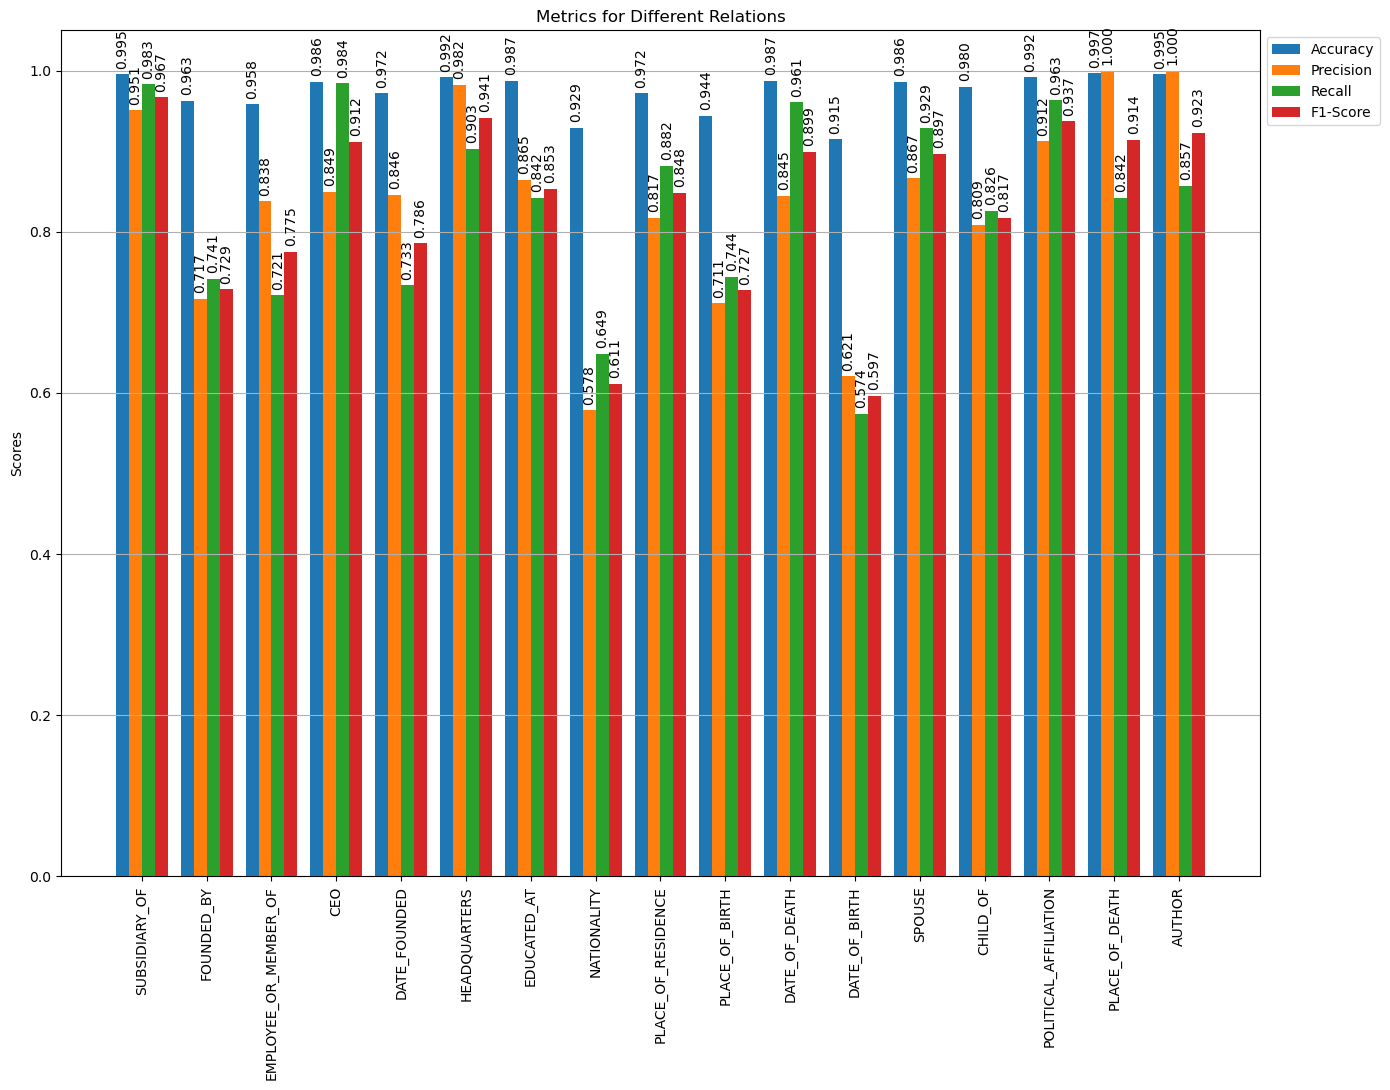

In [27]:
df_prov = rel_metr_df[['RELATION','Accuracy', 'Precision', 'Recall', 'F1-Score']][:17]

import matplotlib.pyplot as plt
import numpy as np

# Selecting relations and scores for plotting
relations = df_prov['RELATION']
scores = df_prov[['Accuracy', 'Precision', 'Recall', 'F1-Score']]

x = np.arange(len(relations))
width = 0.2  # the width of the bars
multiplier = 0


fig, ax = plt.subplots(figsize=(14, 11)) #size of whole plot

for attribute, measurement in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, labels=[f'{val:.3f}' for val in measurement], padding=4, rotation=90)
    #ax.bar_label(rects, padding=0)
    multiplier += 1

ax.grid(axis='y')
ax.set_ylabel('Scores')
ax.set_title('Metrics for Different Relations')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(relations, rotation=90)
#ax.legend()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Save DataFrame for TP, FP, FN Results**

In [ ]:
# File path to save the Excel file
csv_file_path = '../../output/tp.csv'

# Save the DataFrame to an Excel file
tp_df.to_csv(csv_file_path, index=False)

# Provide a link to download the file
from IPython.display import FileLink
display(FileLink(csv_file_path))

In [ ]:
# File path to save the Excel file
csv_file_path = '../../output/fp.csv'

# Save the DataFrame to an Excel file
fp_df.to_csv(csv_file_path, index=False)

# Provide a link to download the file
from IPython.display import FileLink
display(FileLink(csv_file_path))

In [ ]:
# File path to save the Excel file
csv_file_path = '../../output/fn.csv'

# Save the DataFrame to an Excel file
fn_df.to_csv(csv_file_path, index=False)

# Provide a link to download the file
from IPython.display import FileLink
display(FileLink(csv_file_path))

In [ ]:
# File path to save the Excel file
csv_file_path = '../../output/metrics.csv'

# Save the DataFrame to an Excel file
rel_metr_df.to_csv(csv_file_path, index=False)

# Provide a link to download the file
from IPython.display import FileLink
display(FileLink(csv_file_path))

## 6. FewShot-Learning Experiment
The following section, provides an intuition about the amount of necessary data in order to succefully implement such an RE model with BERT. This is done by evaluating the model with different amounts of training data, while maintaining the same testing set. Additionally, it is important to adjust the threshold when classifying the results, in order to obtain the best possible performance.

### 6.A. Necessary Methods and Variables
All the steps from section 4 were embedded into methods into the script my_trainer.py, in order to keep the Jupyter Notebook readable.

In [13]:
import sys
sys.path.append('../..')

#from my_trainer import *
import my_trainer as mytr

treshli = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6]
fshot_names = ["df_fshot_5", "df_fshot_10", "df_fshot_15", "df_fshot_20", "df_fshot_25", "df_fshot_30", "df_fshot35", "df_fshot_40", "df_fshot_45", "df_fshot_50", "df_fshot_80"]

Script was successfully imported


### 6.B. DataSet Subdivision
In order to perform the experiment, we need to correctly select from each relation a dataset corresponding to the amounts (i.e. 5,10,15,...,50,80). This means we will have for each relation 11 datasets.

In [28]:
df_fshot_5 = pd.DataFrame()
df_fshot_10 = pd.DataFrame()
df_fshot_15 = pd.DataFrame()
df_fshot_20 = pd.DataFrame()
df_fshot_25 = pd.DataFrame()
df_fshot_30 = pd.DataFrame()
df_fshot_35 = pd.DataFrame()
df_fshot_40 = pd.DataFrame()
df_fshot_45 = pd.DataFrame()
df_fshot_50 = pd.DataFrame()
df_fshot_80 = pd.DataFrame()

amounts = [5,10,15,20,25,30,35,40,45,50,80]
few_shot_dfs = [df_fshot_5, df_fshot_10, df_fshot_15, df_fshot_20, df_fshot_25, df_fshot_30, df_fshot_35, df_fshot_40, df_fshot_45, df_fshot_50, df_fshot_80]
fshot_names = ["df_fshot_5", "df_fshot_10", "df_fshot_15", "df_fshot_20", "df_fshot_25", "df_fshot_30", "df_fshot_35", "df_fshot_40", "df_fshot_45", "df_fshot_50", "df_fshot_80"]

rels = ["SUBSIDIARY_OF", "FOUNDED_BY", "EMPLOYEE_OR_MEMBER_OF", "CEO", "DATE_FOUNDED", "HEADQUARTERS", "EDUCATED_AT", "NATIONALITY", "PLACE_OF_RESIDENCE", "PLACE_OF_BIRTH", "DATE_OF_DEATH", "DATE_OF_BIRTH", "SPOUSE", "CHILD_OF", "POLITICAL_AFFILIATION", "PLACE_OF_DEATH", "AUTHOR", "DEATH"]
all_label = [["SUBSIDIARY_OF"], ["FOUNDED_BY"], ["EMPLOYEE_OR_MEMBER_OF"], ["CEO"], ["DATE_FOUNDED"], ["HEADQUARTERS"], ["EDUCATED_AT"], ["NATIONALITY"], ["PLACE_OF_RESIDENCE"], ["PLACE_OF_BIRTH"], ["DATE_OF_DEATH"], ["DATE_OF_BIRTH"], ["SPOUSE"], ["CHILD_OF"], ["POLITICAL_AFFILIATION"], ["PLACE_OF_DEATH"], ["AUTHOR"], ["PLACE_OF_DEATH", "DATE_OF_DEATH"]]
all_label_vec = list(map(label_to_multilabelVec, all_label))

dict_dfs = {}

for a, f, n in zip(amounts,few_shot_dfs,fshot_names):
    
    for i, j in zip(rels,all_label_vec):
        
        amount = a

        if amount == 80 and (i == "PLACE_OF_DEATH" or i == "AUTHOR"):
            if i == "PLACE_OF_DEATH":
                temp = train_df[train_df["label"].apply(lambda x: x[15] == 1)]
            else:
                temp = train_df[train_df["label"].apply(lambda x: x[16] == 1)]

        elif i == "DEATH":
            amount = (amount//3)
            temp = train_df[train_df["label"].apply(lambda x: x == j)].head(amount)

        elif i == "PLACE_OF_DEATH" or i == "DATE_OF_DEATH":
            amount = amount-(amount//3)
            temp = train_df[train_df["label"].apply(lambda x: x == j)].head(amount)
            
        else:
            temp = train_df[train_df["label"].apply(lambda x: x == j)].head(amount)
        #print(temp)
        f = pd.concat([f,temp])
        
    # shuffle
    f = f.sample(frac=1).reset_index(drop=True)
    dict_dfs[n] = f
    
#dict_dfs["df_fshot_80"]

### 6.C. Running the FewShot-Learning Experiment (Re-Training)
The following cell trains and saves all the datasets and evaluates the over many different threshold.

In [ ]:
result_fshot = []
grouped_dt = {}

max_sequence_length1 = 128
batch_size1 = 8
num_epochs1 = 10
learning_rate1 = 2e-5
result_fshot = []

for i,z in zip(fshot_names,[5,10,15,20,25,30,35,40,45,50,80]):
    model = mytr.trainee(dict_dfs[i])
    mytr.save_model(model, i, batch_size1,num_epochs1, learning_rate1, max_sequence_length1)
    print(i, "\n")
    for t in treshli:
        res = mytr.evaluator(val_df, model,t,z)
        result_fshot.append(res)
        
#print(result_fshot)

### 6.D. Running the FewShot-Learning Experiment (Already trained)
If the different models corresponding to the 11 different datasets were already trained and saved once (cf. 6.C.), we can just load them and evaluate them.

In [31]:
result_fshot = []
grouped_dt = {}

for i,z in zip(fshot_names, [5,10,15,20,25,30,35,40,45,50,80]):
    path = i + ".pth"
    fmodel = mytr.model_loader(path)
    for t in treshli:
        res = mytr.evaluator(val_df, fmodel, t, z)
        result_fshot.append(res)

for threshold, score, amount in result_fshot:
    if amount not in grouped_dt or score > grouped_dt[amount][0]:
        grouped_dt[amount] = (score, threshold)

result = [(value[1], value[0], key) for key, value in grouped_dt.items()]
#result

Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.80it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.64it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.61it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.73it/s]


Threshold:       0.1
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.73it/s]


Threshold:       0.15
Accuracy: 0.00%
Precision: 7.37%
Recall: 90.69%
F1-Score: 13.64%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.55it/s]


Threshold:       0.2
Accuracy: 0.12%
Precision: 10.28%
Recall: 54.55%
F1-Score: 17.30%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.65it/s]


Threshold:       0.25
Accuracy: 0.35%
Precision: 9.88%
Recall: 1.58%
F1-Score: 2.73%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.80it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.3
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.71it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.35
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.73it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.4
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.75it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.45
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.72it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.5
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.71it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.6
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.64it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.43it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.73it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.63it/s]


Threshold:       0.1
Accuracy: 0.00%
Precision: 7.87%
Recall: 90.59%
F1-Score: 14.49%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.65it/s]


Threshold:       0.15
Accuracy: 4.42%
Precision: 40.44%
Recall: 9.01%
F1-Score: 14.74%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.66it/s]


Threshold:       0.2
Accuracy: 0.58%
Precision: 100.00%
Recall: 0.79%
F1-Score: 1.57%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.68it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.25
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.66it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.3
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.67it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.35
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.62it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.4
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.69it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.45
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.63it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.5
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.66it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.6
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.41it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.42it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.40it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.40it/s]


Threshold:       0.1
Accuracy: 2.79%
Precision: 17.79%
Recall: 18.61%
F1-Score: 18.19%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.41it/s]


Threshold:       0.15
Accuracy: 1.63%
Precision: 57.14%
Recall: 1.58%
F1-Score: 3.08%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.34it/s]


Threshold:       0.2
Accuracy: 0.23%
Precision: 66.67%
Recall: 0.20%
F1-Score: 0.39%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.45it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.25
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.35it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.3
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.59it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.35
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.56it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.4
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.59it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.45
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.59it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.5
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.41it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.6
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:26<00:00,  4.01it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.71it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.61it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 7.11%
Recall: 100.00%
F1-Score: 13.28%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.49it/s]


Threshold:       0.1
Accuracy: 7.92%
Precision: 24.74%
Recall: 51.68%
F1-Score: 33.46%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.27it/s]


Threshold:       0.15
Accuracy: 6.05%
Precision: 54.60%
Recall: 9.41%
F1-Score: 16.05%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.35it/s]


Threshold:       0.2
Accuracy: 3.96%
Precision: 68.49%
Recall: 4.95%
F1-Score: 9.23%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.34it/s]


Threshold:       0.25
Accuracy: 3.14%
Precision: 86.49%
Recall: 3.17%
F1-Score: 6.11%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.28it/s]


Threshold:       0.3
Accuracy: 1.28%
Precision: 88.24%
Recall: 1.49%
F1-Score: 2.92%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.28it/s]


Threshold:       0.35
Accuracy: 0.47%
Precision: 100.00%
Recall: 0.69%
F1-Score: 1.38%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.31it/s]


Threshold:       0.4
Accuracy: 0.12%
Precision: 100.00%
Recall: 0.30%
F1-Score: 0.59%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.31it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.45
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.30it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.5
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.29it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.6
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.48it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.46it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.42it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 7.45%
Recall: 99.90%
F1-Score: 13.87%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.45it/s]


Threshold:       0.1
Accuracy: 5.01%
Precision: 26.37%
Recall: 73.07%
F1-Score: 38.75%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.51it/s]


Threshold:       0.15
Accuracy: 16.07%
Precision: 51.39%
Recall: 40.20%
F1-Score: 45.11%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.50it/s]


Threshold:       0.2
Accuracy: 17.93%
Precision: 80.51%
Recall: 18.81%
F1-Score: 30.50%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.50it/s]


Threshold:       0.25
Accuracy: 10.48%
Precision: 90.99%
Recall: 10.00%
F1-Score: 18.02%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.48it/s]


Threshold:       0.3
Accuracy: 4.77%
Precision: 93.75%
Recall: 4.46%
F1-Score: 8.51%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.52it/s]


Threshold:       0.35
Accuracy: 0.47%
Precision: 88.89%
Recall: 0.79%
F1-Score: 1.57%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.49it/s]


Threshold:       0.4
Accuracy: 0.35%
Precision: 85.71%
Recall: 0.59%
F1-Score: 1.18%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.52it/s]


Threshold:       0.45
Accuracy: 0.12%
Precision: 100.00%
Recall: 0.20%
F1-Score: 0.40%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.46it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.5
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.45it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.6
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.64it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.64it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.64it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 8.01%
Recall: 99.70%
F1-Score: 14.83%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.49it/s]


Threshold:       0.1
Accuracy: 2.68%
Precision: 23.51%
Recall: 87.33%
F1-Score: 37.04%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.60it/s]


Threshold:       0.15
Accuracy: 19.21%
Precision: 49.92%
Recall: 63.37%
F1-Score: 55.85%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.51it/s]


Threshold:       0.2
Accuracy: 28.64%
Precision: 69.77%
Recall: 41.58%
F1-Score: 52.11%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.56it/s]


Threshold:       0.25
Accuracy: 16.07%
Precision: 76.47%
Recall: 19.31%
F1-Score: 30.83%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.60it/s]


Threshold:       0.3
Accuracy: 7.57%
Precision: 77.78%
Recall: 9.01%
F1-Score: 16.15%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.66it/s]


Threshold:       0.35
Accuracy: 3.84%
Precision: 81.03%
Recall: 4.65%
F1-Score: 8.80%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.71it/s]


Threshold:       0.4
Accuracy: 1.28%
Precision: 89.47%
Recall: 1.68%
F1-Score: 3.30%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.43it/s]


Threshold:       0.45
Accuracy: 0.23%
Precision: 100.00%
Recall: 0.50%
F1-Score: 0.99%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.69it/s]


Threshold:       0.5
Accuracy: 0.00%
Precision: 100.00%
Recall: 0.20%
F1-Score: 0.40%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:22<00:00,  4.70it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.6
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:26<00:00,  4.11it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.22it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.31it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 8.67%
Recall: 99.41%
F1-Score: 15.95%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.32it/s]


Threshold:       0.1
Accuracy: 6.75%
Precision: 30.18%
Recall: 74.65%
F1-Score: 42.99%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.31it/s]


Threshold:       0.15
Accuracy: 14.90%
Precision: 51.54%
Recall: 44.65%
F1-Score: 47.85%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.35it/s]


Threshold:       0.2
Accuracy: 21.19%
Precision: 66.29%
Recall: 28.81%
F1-Score: 40.17%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.34it/s]


Threshold:       0.25
Accuracy: 17.93%
Precision: 82.14%
Recall: 18.22%
F1-Score: 29.82%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.38it/s]


Threshold:       0.3
Accuracy: 13.39%
Precision: 91.03%
Recall: 13.07%
F1-Score: 22.86%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.29it/s]


Threshold:       0.35
Accuracy: 7.22%
Precision: 94.67%
Recall: 7.03%
F1-Score: 13.09%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.17it/s]


Threshold:       0.4
Accuracy: 4.31%
Precision: 95.74%
Recall: 4.46%
F1-Score: 8.51%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.26it/s]


Threshold:       0.45
Accuracy: 2.21%
Precision: 96.30%
Recall: 2.57%
F1-Score: 5.01%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.37it/s]


Threshold:       0.5
Accuracy: 0.93%
Precision: 100.00%
Recall: 1.09%
F1-Score: 2.15%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.41it/s]
/Users/tariktornes/Documents/UniLux/Semester 3/BSPS3/PyTorchEnvs/pytorch-test1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold:       0.6
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.67it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.67it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.67it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 10.96%
Recall: 98.91%
F1-Score: 19.74%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.64it/s]


Threshold:       0.1
Accuracy: 4.89%
Precision: 29.41%
Recall: 86.63%
F1-Score: 43.91%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.66it/s]


Threshold:       0.15
Accuracy: 20.49%
Precision: 46.91%
Recall: 66.04%
F1-Score: 54.85%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.65it/s]


Threshold:       0.2
Accuracy: 27.71%
Precision: 62.95%
Recall: 45.25%
F1-Score: 52.65%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.65it/s]


Threshold:       0.25
Accuracy: 20.95%
Precision: 72.86%
Recall: 25.25%
F1-Score: 37.50%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.65it/s]


Threshold:       0.3
Accuracy: 14.67%
Precision: 86.63%
Recall: 14.75%
F1-Score: 25.21%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:26<00:00,  4.10it/s]


Threshold:       0.35
Accuracy: 9.31%
Precision: 90.91%
Recall: 8.91%
F1-Score: 16.23%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.59it/s]


Threshold:       0.4
Accuracy: 5.01%
Precision: 94.34%
Recall: 4.95%
F1-Score: 9.41%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.64it/s]


Threshold:       0.45
Accuracy: 2.10%
Precision: 88.00%
Recall: 2.18%
F1-Score: 4.25%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.61it/s]


Threshold:       0.5
Accuracy: 1.28%
Precision: 93.75%
Recall: 1.49%
F1-Score: 2.92%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.62it/s]


Threshold:       0.6
Accuracy: 0.12%
Precision: 100.00%
Recall: 0.20%
F1-Score: 0.40%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.17it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:28<00:00,  3.78it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.19it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 10.84%
Recall: 99.11%
F1-Score: 19.54%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.16it/s]


Threshold:       0.1
Accuracy: 5.24%
Precision: 33.19%
Recall: 90.20%
F1-Score: 48.52%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.18it/s]


Threshold:       0.15
Accuracy: 35.51%
Precision: 59.52%
Recall: 74.26%
F1-Score: 66.08%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.16it/s]


Threshold:       0.2
Accuracy: 44.24%
Precision: 70.80%
Recall: 60.99%
F1-Score: 65.53%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.16it/s]


Threshold:       0.25
Accuracy: 44.00%
Precision: 78.88%
Recall: 51.39%
F1-Score: 62.23%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:26<00:00,  4.02it/s]


Threshold:       0.3
Accuracy: 39.12%
Precision: 83.46%
Recall: 41.98%
F1-Score: 55.86%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:28<00:00,  3.83it/s]


Threshold:       0.35
Accuracy: 29.69%
Precision: 87.64%
Recall: 30.20%
F1-Score: 44.92%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:28<00:00,  3.75it/s]


Threshold:       0.4
Accuracy: 18.39%
Precision: 89.37%
Recall: 18.32%
F1-Score: 30.40%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:27<00:00,  3.90it/s]


Threshold:       0.45
Accuracy: 9.08%
Precision: 89.42%
Recall: 9.21%
F1-Score: 16.70%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:29<00:00,  3.66it/s]


Threshold:       0.5
Accuracy: 4.42%
Precision: 97.87%
Recall: 4.55%
F1-Score: 8.70%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.27it/s]


Threshold:       0.6
Accuracy: 0.00%
Precision: 100.00%
Recall: 0.10%
F1-Score: 0.20%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:23<00:00,  4.51it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.49it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.44it/s]


Threshold:       0.05
Accuracy: 0.00%
Precision: 11.24%
Recall: 98.02%
F1-Score: 20.16%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.39it/s]


Threshold:       0.1
Accuracy: 9.20%
Precision: 35.93%
Recall: 88.71%
F1-Score: 51.14%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.37it/s]


Threshold:       0.15
Accuracy: 38.65%
Precision: 60.76%
Recall: 77.43%
F1-Score: 68.09%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.46it/s]


Threshold:       0.2
Accuracy: 48.54%
Precision: 72.76%
Recall: 64.26%
F1-Score: 68.24%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.45it/s]


Threshold:       0.25
Accuracy: 45.29%
Precision: 80.73%
Recall: 50.59%
F1-Score: 62.20%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.46it/s]


Threshold:       0.3
Accuracy: 36.09%
Precision: 85.00%
Recall: 37.03%
F1-Score: 51.59%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:24<00:00,  4.49it/s]


Threshold:       0.35
Accuracy: 29.10%
Precision: 89.30%
Recall: 28.91%
F1-Score: 43.68%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [01:19<00:00,  1.36it/s]


Threshold:       0.4
Accuracy: 20.72%
Precision: 90.54%
Recall: 19.90%
F1-Score: 32.63%


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a1a18558-3eb3-4db7-9cc1-a7090454b7cb)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json


Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [07:05<00:00,  3.94s/it]


Threshold:       0.45
Accuracy: 13.62%
Precision: 92.65%
Recall: 12.48%
F1-Score: 21.99%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [02:20<00:00,  1.30s/it]


Threshold:       0.5
Accuracy: 7.80%
Precision: 94.74%
Recall: 7.13%
F1-Score: 13.26%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [33:36<00:00, 18.67s/it]


Threshold:       0.6
Accuracy: 0.35%
Precision: 100.00%
Recall: 0.50%
F1-Score: 0.99%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:26<00:00,  4.15it/s]


Threshold:       0.001
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.94%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:26<00:00,  4.08it/s]


Threshold:       0.01
Accuracy: 0.00%
Precision: 6.92%
Recall: 100.00%
F1-Score: 12.95%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.17it/s]


Threshold:       0.05
Accuracy: 2.91%
Precision: 30.20%
Recall: 95.74%
F1-Score: 45.92%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.17it/s]


Threshold:       0.1
Accuracy: 41.44%
Precision: 59.80%
Recall: 90.30%
F1-Score: 71.95%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:26<00:00,  4.09it/s]


Threshold:       0.15
Accuracy: 56.11%
Precision: 70.04%
Recall: 86.34%
F1-Score: 77.34%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.19it/s]


Threshold:       0.2
Accuracy: 59.72%
Precision: 73.59%
Recall: 82.48%
F1-Score: 77.78%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.24it/s]


Threshold:       0.25
Accuracy: 61.47%
Precision: 75.71%
Recall: 79.01%
F1-Score: 77.33%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.31it/s]


Threshold:       0.3
Accuracy: 61.70%
Precision: 77.13%
Recall: 75.45%
F1-Score: 76.28%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.28it/s]


Threshold:       0.35
Accuracy: 62.05%
Precision: 79.16%
Recall: 72.57%
F1-Score: 75.72%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.30it/s]


Threshold:       0.4
Accuracy: 61.70%
Precision: 80.84%
Recall: 68.51%
F1-Score: 74.17%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.28it/s]


Threshold:       0.45
Accuracy: 60.30%
Precision: 83.66%
Recall: 63.86%
F1-Score: 72.43%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.29it/s]


Threshold:       0.5
Accuracy: 57.97%
Precision: 86.68%
Recall: 59.90%
F1-Score: 70.84%
Number of test examples: 859
Test text example: The Secretary of the Navy was, from its creation in 1798, a member of the President's Cabinet until 1949, when the Secretary of the Navy (and the Secretaries of the Army and Air Force) was by amendments to the National Security Act of 1947 made subordinate to the Secretary of Defense.
Test label example: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:25<00:00,  4.31it/s]

Threshold:       0.6
Accuracy: 52.39%
Precision: 90.29%
Recall: 52.48%
F1-Score: 66.37%


### 6.E. Ploting the results of the Experiment

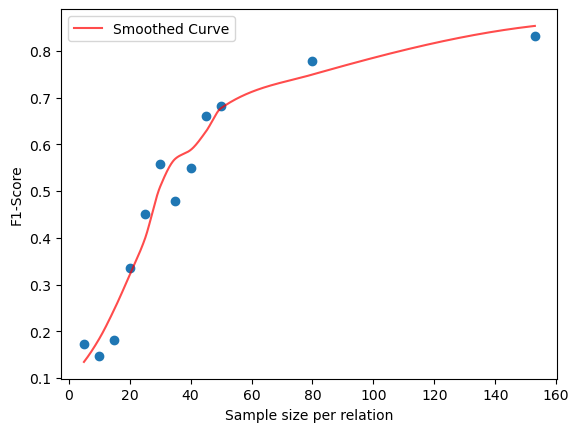

In [32]:
import numpy as np
from scipy.interpolate import PchipInterpolator
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

x = []
y = []

for i in result:
    x.append(i[2])
    y.append(i[1])

# size of all trainingset divided by #of relations
x.append(153)

y.append(rel_metr_df["F1-Score"].loc[17])
x = np.array(x)
y = np.array(y)

sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]


window_length = 10
y_smoothed = savgol_filter(y_sorted, window_length, 3)  # 3rd order polynomial

# Fit a curve to the smoothed data using Pchip interpolation
smooth_interp = PchipInterpolator(x_sorted, y_smoothed)

# Generate points for the curve
x_curve = np.linspace(min(x), max(x), 1000)
y_interp_curve = smooth_interp(x_curve)

# Plotting the original data, the smoothed curve
plt.scatter(x, y)
#plt.plot(x_sorted, y_smoothed, label='Smoothed Curve', color='blue')
plt.plot(x_curve, y_interp_curve, label='Smoothed Curve', color='red', alpha=0.7)
plt.xlabel('Sample size per relation')
plt.ylabel('F1-Score')
plt.legend()
plt.show()


## 7. EXTRA: Threshold testing
This section illustrates, how the scores vary with changing threshold.

In [14]:
# token = BertTokenizer.from_pretrained('bert-base-uncased')
def pred_tresh(token, val_df, thresh):
    tokenizer = token
    res = pd.DataFrame(columns=["text", "KN_label", "My_label"])
    res["text"] = val_df["passageText"]
    res["KN_label"] = val_df["label"]
    res["My_label"] = res["text"].apply(lambda x: list(map(int,predict_labels(x, model, tokenizer, max_sequence_length, thresh).tolist()[0])))
    return res

In [20]:
treshli = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6]
tok = BertTokenizer.from_pretrained('bert-base-uncased')
ls_author = []
ls_POD = []
ls_total = []

for i in treshli:
    lo = pred_tresh(tok, val_df, i)
    lu = mytr.evaluator_3(lo,i, train_df)
    ls_POD.append((lu[0],lu[1]['F1-Score'][15]))
    ls_author.append((lu[0],lu[1]['F1-Score'][16]))
    ls_total.append((lu[0], lu[1]['F1-Score'][17]))
    print('POD   ', lu[0], ":  ",   lu[1]['F1-Score'][15])
    print('AUTHOR', lu[0], ":  ",   lu[1]['F1-Score'][16])
    print('MACRO ', lu[0], ":  ",   lu[1]['F1-Score'][17], '\n')

POD    0.001 :   0.04328018223234624
AUTHOR 0.001 :   0.06313416009019164
MACRO  0.001 :   0.1285283727858405 

POD    0.01 :   0.06998158379373848
AUTHOR 0.01 :   0.08092485549132947
MACRO  0.01 :   0.14380399069187155 

POD    0.05 :   0.59375
AUTHOR 0.05 :   0.7567567567567568
MACRO  0.05 :   0.6863672691488288 

POD    0.1 :   0.7659574468085106
AUTHOR 0.1 :   0.9032258064516129
MACRO  0.1 :   0.8017286764257165 

POD    0.15 :   0.8181818181818181
AUTHOR 0.15 :   0.9473684210526316
MACRO  0.15 :   0.8270121774395088 

POD    0.2 :   0.7804878048780488
AUTHOR 0.2 :   0.9285714285714286
MACRO  0.2 :   0.826777223932848 

POD    0.25 :   0.8205128205128205
AUTHOR 0.25 :   0.9454545454545454
MACRO  0.25 :   0.8325594006483646 

POD    0.3 :   0.8421052631578947
AUTHOR 0.3 :   0.9433962264150945
MACRO  0.3 :   0.8332550606659255 

POD    0.35 :   0.8888888888888888
AUTHOR 0.35 :   0.9433962264150945
MACRO  0.35 :   0.8339089183950861 

POD    0.4 :   0.9142857142857143
AUTHOR 0.4 :   0

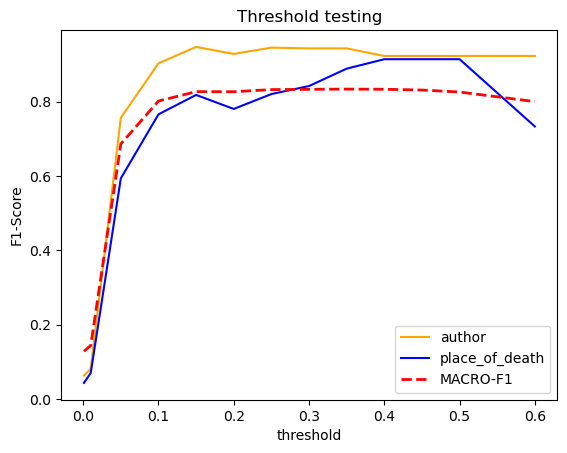

In [22]:
y_auth = [scr[1] for scr in ls_author]
y_pod = [scr[1] for scr in ls_POD]
y_total = [scr[1] for scr in ls_total]

plt.plot(treshli, y_auth, label='author', color='orange', linestyle='-')

plt.plot(treshli, y_pod, label='place_of_death', color='blue', linestyle='-')

plt.plot(treshli, y_total, label='MACRO-F1', color='red', linestyle='--', linewidth = '2')


plt.xlabel('threshold')
plt.ylabel('F1-Score')
plt.title('Threshold testing')


plt.legend()

plt.show()